<a href="https://colab.research.google.com/github/Praxis-QR/DeepLearning/blob/main/AI_DL_Chapter_8_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://1.bp.blogspot.com/-WAjYIaQofo0/YEB0cQsSGSI/AAAAAAAAkoE/TpQcWBRGtu0N010lmiTS9cFHuGwXB45PQCLcBGAsYHQ/s16000/colabHeader00.png)<br>

<hr>

[Prithwis Mukerjee](http://www.yantrajaal.com) / [Praxis Business School](http://praxis.ac.in/) / [Book Website](http://aidl4managers.blogspot.com) 

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
#from keras.optimizers import Adam -- https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [9]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [10]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('Accuracy real images : %.0f%%, fake images: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [15]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            if j == bat_per_epo-1:
                print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        #if (i+1) % 10 == 0:                            # save images afer every 10 epochs
        if (i+1) % 3 == 0:                              # save images after every 3 epochs
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [16]:
# size of the latent space
latent_dim = 100
# create the discriminator
Checker = define_discriminator()
# create the generator
Faker = define_generator(latent_dim)
# create the gan
FC_Combo = define_gan(Faker, Checker)
#
numberOfEpochs = 9    # should be > 100 for proper results, but each epoch will take ~ 1 min to run
batchSize = 256

In [13]:
# load image data
dataset = load_real_samples()

11490434/11490434 [==============================] - 2s 0us/step


In [17]:
%%time
# train model
train(Faker, Checker, FC_Combo, dataset, latent_dim,numberOfEpochs, batchSize)

4/4 [==============================] - 0s 4ms/step
>1, 234/234, d=0.663, g=0.773
4/4 [==============================] - 0s 4ms/step
>2, 234/234, d=0.621, g=0.802
4/4 [==============================] - 0s 5ms/step
>3, 234/234, d=0.715, g=0.688
4/4 [==============================] - 0s 16ms/step
Accuracy real images : 31%, fake images: 46%


4/4 [==============================] - 0s 4ms/step
>4, 234/234, d=0.675, g=0.731
4/4 [==============================] - 0s 4ms/step
>5, 234/234, d=0.676, g=0.715
4/4 [==============================] - 0s 4ms/step
>6, 234/234, d=0.697, g=0.681
4/4 [==============================] - 0s 4ms/step
Accuracy real images : 63%, fake images: 34%


4/4 [==============================] - 0s 4ms/step
>7, 234/234, d=0.690, g=0.704
4/4 [==============================] - 0s 4ms/step
>8, 234/234, d=0.682, g=0.682
4/4 [==============================] - 0s 4ms/step
>9, 234/234, d=0.692, g=0.767
4/4 [==============================] - 0s 5ms/step
Accuracy real images : 8%, fake images: 100%


CPU times: user 4min 27s, sys: 8.87 s, total: 4min 36s
Wall time: 5min 7s


In [18]:
# Retrieve previously generated / stored images
#
!rm *.png
!wget -q https://github.com/Praxis-QR/DeepLearning/raw/main/GANoutput/GANoutput.zip
!unzip GANoutput.zip

Archive:  GANoutput.zip
  inflating: generated_plot_e010.png  
  inflating: generated_plot_e040.png  
  inflating: generated_plot_e060.png  
  inflating: generated_plot_e100.png  
  inflating: generated_plot_e080.png  
  inflating: generated_plot_e020.png  
  inflating: generated_plot_e050.png  
  inflating: generated_plot_e070.png  
  inflating: generated_plot_e030.png  
  inflating: generated_plot_e090.png  


In [19]:
import cv2
from matplotlib import pyplot as plt
# https://colab.research.google.com/drive/1qVdz2ClR9x2Ig7IezGSnw1K8qhBGRoGU?usp=sharing#scrollTo=hNepVUHN0SDe

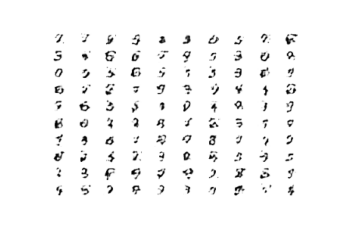

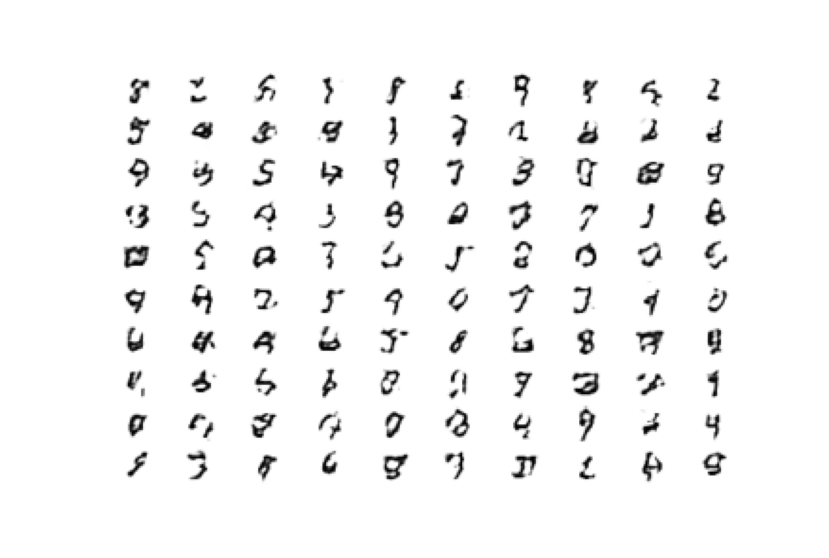

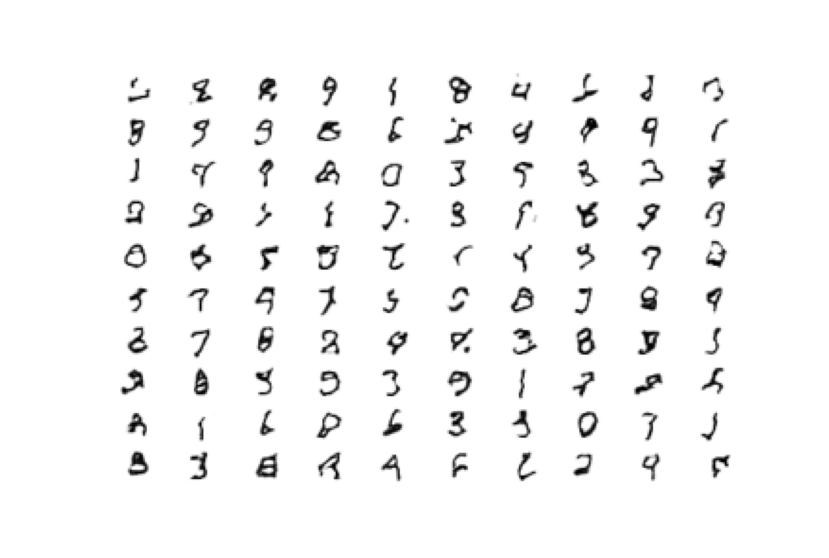

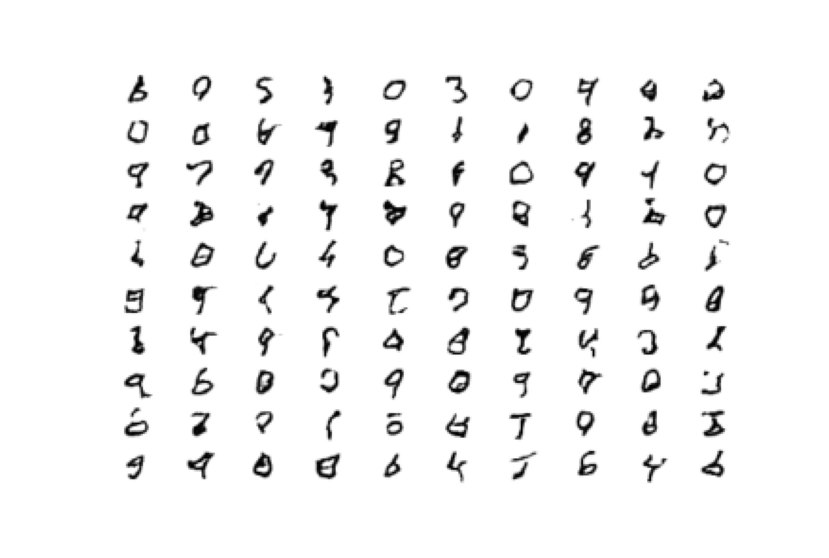

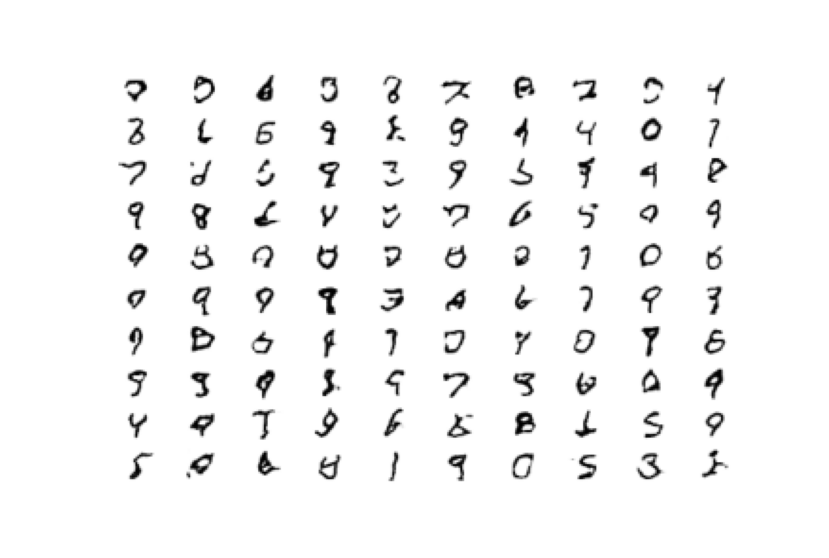

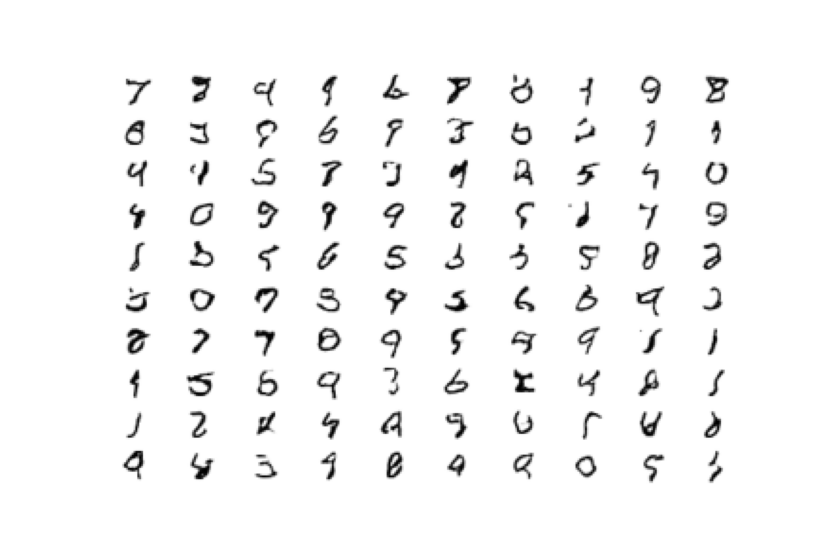

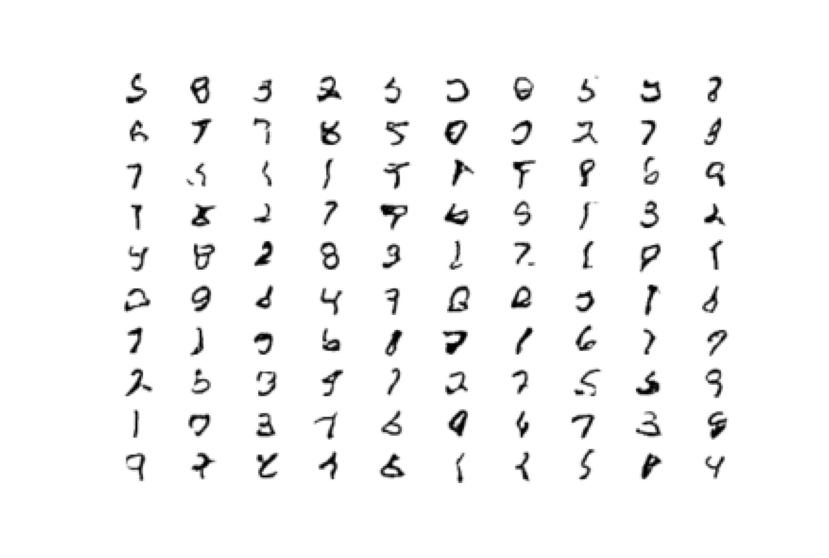

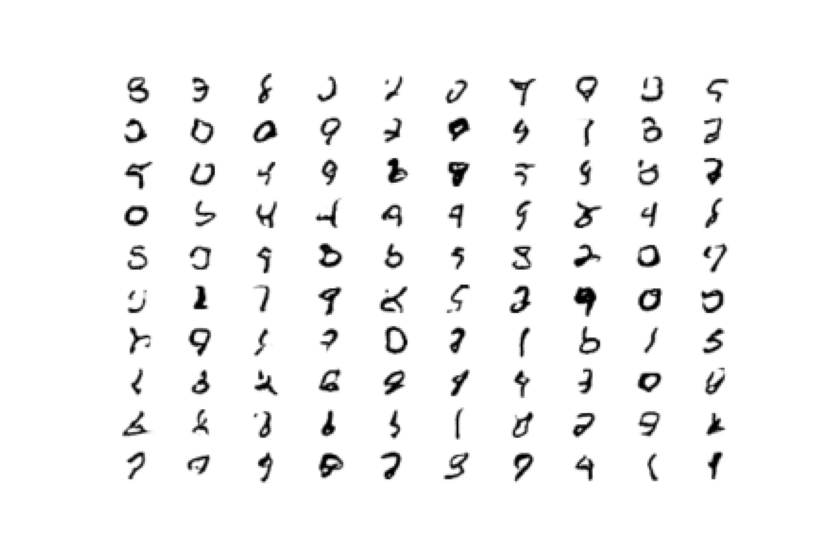

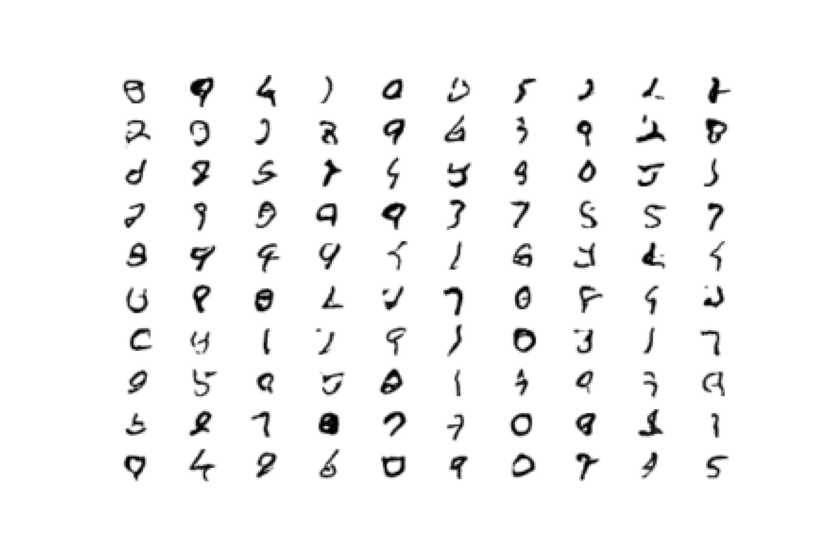

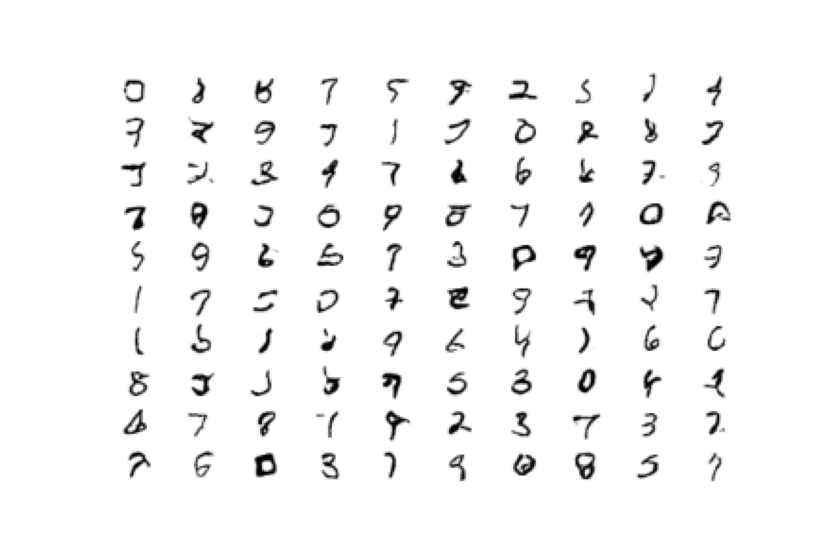

In [20]:
# Display generated images
#
for s in ['010','020','030','040','050','060','070','080','090','100']:
    imgPath = 'generated_plot_e'+s+'.png'
    img = cv2.imread(imgPath,1)
    plt.imshow(img)
    plt.rcParams["figure.figsize"] = (20,10)
    plt.axis("off")
    plt.show()
    #sleep(3)
    #plt.clf()

In [21]:
##Last Tested
!date

Sun Nov 27 03:52:17 UTC 2022


#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png) The contents of this website are released under creative commons 